In [ ]:
from huggingface_hub import login
login(token='')

Install required packages

In [ ]:
%%capture
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl

Need to install this particular pyarrow version to avoid issues with datasets

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

Load and initialize the model, the tokenizer and the pipe function from transformers library

In [ ]:
from transformers import AutoTokenizer,AutoModelForCausalLM,pipeline
import torch

base_model = "meta-llama/Llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(base_model)

model = AutoModelForCausalLM.from_pretrained(
        base_model,
        return_dict=True,
        low_cpu_mem_usage=True, #Tries not to use more than 1x model size in CPU memory
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",
)

Load the dataset

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/test_food_bev_alc.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
df.head(3)

,product,label,link,typeID
0,New Belgium Brewing Fat Tire Ale12 fl oz,alcohol/beer/ales/amber red ale,https://www.instacart.com//products/16753468-n...,0
1,"Yuengling Beer, Traditional Lager, 24 Pack12 f...",alcohol/beer/ales/amber red ale,https://www.instacart.com//products/125873-yue...,0
2,George Killian's Irish Red Lager Beer12 fl oz,alcohol/beer/ales/amber red ale,https://www.instacart.com//products/307193-geo...,0


In [ ]:
df['Category']=[df['label'][i].split('/')[1] for i in range(len(df))]
df.drop(['link','typeID'],axis=1,inplace=True)
print("###### SAMPLE OF DATAFRAME #######")
print(df.sample(3))
print('##### LIST OF CATEGORIES #######')
print(df['Category'].unique())

###### SAMPLE OF DATAFRAME #######
                                                 product  \
17629   Vadilal Quick Treat Whole Wheat Phulka Roti250 g   
23080  Nathan’s Famous Beef Franks, Colosal, Quarter ...   
61432                Sun Luck Sliced Water Chestnuts8 oz   

                                                   label     Category  
17629                   food/baked goods/flatbreads/roti  baked goods  
23080                        food/meat/sausages/hot dogs         meat  
61432  food/pantry/canned goods/canned vegetables/can...       pantry  
##### LIST OF CATEGORIES #######
['beer' 'alcohol making kits' 'cocktail accessories' 'spirits' 'wine'
 'coffee' 'juice' 'powdered drinks' 'soda' 'tea' 'water' 'deli'
 'baked goods' 'dairy' 'meat' 'seafood' 'fresh produce' 'frozen food'
 'meat alternatives' 'pantry']


In [ ]:
labels=df.Category.unique()
sub_df=df.Category.value_counts()
sub_df

,count
Category,
pantry,24499
fresh produce,13952
frozen food,5987
meat,5965
baked goods,4201
dairy,4026
wine,3829
deli,3146
seafood,2169


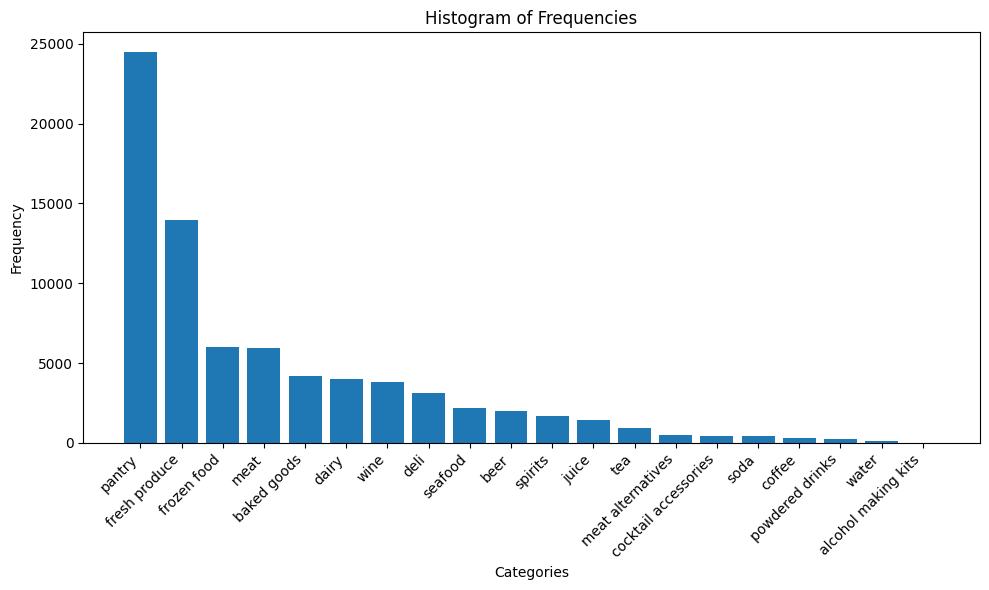

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(sub_df.index, sub_df.values)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Histogram of Frequencies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Balancing the data set and perform train test split. We drop part of the data with not enough data points

In [ ]:
cutoff=600
drop_labels= [label for label in sub_df.index if sub_df[label] < cutoff]
labels= [label for label in sub_df.index if sub_df[label] >= cutoff]
drop_labels

['meat alternatives',
 'cocktail accessories',
 'soda',
 'coffee',
 'powdered drinks',
 'water',
 'alcohol making kits']

In [ ]:
for i in range(len(drop_labels)):
  df = df[df["Category"] != drop_labels[i]]

In [ ]:
min_val=min(df.Category.value_counts())
df.Category.value_counts()


,count
Category,
pantry,24499
fresh produce,13952
frozen food,5987
meat,5965
baked goods,4201
dairy,4026
wine,3829
deli,3146
seafood,2169


In [ ]:
categories = labels
result = {}

for category in categories:
    if category == 'meat alternatives':
      result[category] = df[df['Category'] == category]
    else:
        result[category] = df[df['Category'] == category].sample(n=min_val, random_state=34)


balanced_df=pd.concat(result.values(), ignore_index=True)

In [ ]:
balanced_df.Category.value_counts()

,count
Category,
pantry,952
fresh produce,952
frozen food,952
meat,952
baked goods,952
dairy,952
wine,952
deli,952
seafood,952


In [ ]:
balanced_df = balanced_df.sample(frac=1, random_state=85).reset_index(drop=True)

# Split the DataFrame
train_size = 0.8
eval_size = 0.1

# Calculate sizes
train_end = int(train_size * len(balanced_df))
eval_end = train_end + int(eval_size * len(balanced_df))

# Split the data
X_train = balanced_df[:train_end]
X_eval = balanced_df[train_end:eval_end]
X_test = balanced_df[eval_end:]


In [ ]:
X_train.Category.value_counts()

,count
Category,
seafood,780
baked goods,770
pantry,767
frozen food,766
wine,766
fresh produce,766
tea,763
meat,759
spirits,757


In [ ]:
X_test.Category.value_counts()

,count
Category,
frozen food,104
deli,102
fresh produce,101
pantry,99
wine,98
tea,96
beer,96
spirits,95
seafood,92


In [ ]:
# Define the prompt generation functions
def generate_train_prompt(data_point):
    return f"""
            Classify the text into {', '.join(labels)} and return the answer as the corresponding label.
text: {data_point["product"]}
label: {data_point["Category"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Classify the text into {', '.join(labels)} and return the answer as the corresponding label.
text: {data_point["product"]}
label: """.strip()

X_train = X_train.copy()
X_eval = X_eval.copy()

# Generate prompts for training and evaluation data
X_train.loc[:,'text'] = X_train.apply(generate_train_prompt, axis=1)
X_eval.loc[:,'text'] = X_eval.apply(generate_train_prompt, axis=1)

# Generate test prompts and extract true labels
y_true = X_test.loc[:,'Category']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

In [ ]:
from datasets import Dataset

# Convert to datasets for Hugginface
train_data = Dataset.from_pandas(X_train[["text"]])
eval_data = Dataset.from_pandas(X_eval[["text"]])

In [ ]:
def predict(test, model, tokenizer):

    y_pred = []

    categories = balanced_df.Category.unique()
    # Sort the categories by length in descending order to avoid issues with categories that are substrings of each other (meat vs meat alternatives)
    sorted_categories = sorted(categories, key=len, reverse=True)


    pipe = pipeline(task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=10,
            temperature=0.1)

    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].split("\n")[0].strip()

        y_pred.append(answer.lower())

    return y_pred

y_pred = predict(X_test, model, tokenizer)

100%|██████████| 1239/1239 [14:47<00:00,  1.40it/s]


List of predicted categories

In [ ]:
set(y_pred)

{'',
 '7‑eleven cocktail',
 'absinthe',
 'bagels',
 'baileys',
 'baked goods',
 'beans',
 'beef',
 'beer',
 'beverage',
 'boba',
 'bourbon',
 'bread',
 'cake',
 'candy',
 'cava',
 'caviar',
 'champagne',
 'cheese',
 'chicken',
 'chocolate',
 'coffee',
 'dairy',
 'deli',
 'dressing',
 'fish',
 'fresh',
 'fresh produce',
 'frozen',
 'frozen food',
 'frozen_dessert',
 'frozen_food',
 'gewurztraminer',
 'ginger',
 'gravy',
 'green foods matcha green tea11',
 'ice',
 'ice cream',
 'juice',
 'liquor',
 'matcha',
 'matchabar matcha tea, original1',
 'meat',
 'mezcal',
 'milk',
 'mint',
 'mustard',
 'pantry',
 'peanut butter',
 'pork',
 'rawkin raw spirulina mint super',
 "reese's octopus",
 'relish',
 'rum',
 'salad',
 'salmon',
 'sauce',
 'seafood',
 'smoothie',
 'spice',
 'spirits',
 'sugar',
 'sushi',
 'tea',
 'tropical crema centroamericana',
 'vinegar',
 'whiskey',
 'wine'}

In [ ]:
def evaluate(y_true, y_pred):
    #labels = balanced_df.Category.unique()
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    # Calculate accuracy (with accuracy_score in scikitlearn)
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

evaluate(y_true, y_pred)

Accuracy: 0.576
Accuracy for label pantry: 0.545
Accuracy for label fresh produce: 0.436
Accuracy for label frozen food: 0.144
Accuracy for label meat: 0.733
Accuracy for label baked goods: 0.625
Accuracy for label dairy: 0.545
Accuracy for label wine: 0.939
Accuracy for label deli: 0.147
Accuracy for label seafood: 0.435
Accuracy for label beer: 0.927
Accuracy for label spirits: 0.589
Accuracy for label juice: 0.767
Accuracy for label tea: 0.740

Classification Report:
               precision    recall  f1-score   support

       pantry       0.21      0.55      0.30        99
fresh produce       0.36      0.44      0.39       101
  frozen food       0.83      0.14      0.25       104
         meat       0.70      0.73      0.72        90
  baked goods       0.73      0.62      0.67        88
        dairy       0.86      0.55      0.67        88
         wine       0.95      0.94      0.94        98
         deli       0.88      0.15      0.25       102
      seafood       0.85     

- Accuracy = TP+TN/all
- Precission = TP/(TP+FP)
- Recall=TP/(TP+FN)
- f1 score = 2 * (precission*recall)/(precission+recall)

In [ ]:
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(base_model)

tokenizer.pad_token_id = tokenizer.eos_token_id

In [ ]:
from transformers import Conv1D

def get_specific_layer_names(model):
    # Create a list to store the layer names
    layer_names = []

    # Recursively visit all modules and submodules
    for name, module in model.named_modules():
        # Check if the module is an instance of the specified layers
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding, torch.nn.Conv2d, Conv1D)):
            # model name parsing

            layer_names.append('.'.join(name.split('.')[4:]).split('.')[0])

    return layer_names

modules=list(set(get_specific_layer_names(model)))
modules=modules[1:]
modules

['gate_proj', 'k_proj', 'up_proj', 'o_proj', 'v_proj', 'q_proj', 'down_proj']

In [ ]:
output_dir="llama-fine-tuned-model-3epoch"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=3,                       # number of training epochs
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,              # gradient checkpointing for saving memory
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper (https://proceedings.neurips.cc/paper_files/paper/2023/file/1feb87871436031bdc0f2beaa62a049b-Paper-Conference.pdf)
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",
    eval_strategy="steps",              # save checkpoint every epoch
    eval_steps = 0.2
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=512,
    packing=False,
    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:366: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pass

Map:   0%|          | 0/9900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1237 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
743,0.493600,0.461025
1486,0.349400,0.444401
2229,0.400700,0.427719


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning

Step,Training Loss,Validation Loss
743,0.493600,0.461025
1486,0.349400,0.444401
2229,0.400700,0.427719
2972,0.294700,0.449834


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=3711, training_loss=0.3783403310138753, metrics={'train_runtime': 13859.872, 'train_samples_per_second': 2.143, 'train_steps_per_second': 0.268, 'total_flos': 8.948834669975962e+16, 'train_loss': 0.3783403310138753, 'epoch': 2.998787878787879})

In [ ]:
# Save trained model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-fine-tuned-model-sub/tokenizer_config.json',
 'llama-fine-tuned-model-sub/special_tokens_map.json',
 'llama-fine-tuned-model-sub/tokenizer.model',
 'llama-fine-tuned-model-sub/added_tokens.json',
 'llama-fine-tuned-model-sub/tokenizer.json')

In [ ]:
y_pred = predict(X_test, model, tokenizer)

  0%|          | 0/1239 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 1239/1239 [30:00<00:00,  1.45s/it]


In [ ]:
evaluate(y_true, y_pred)

Accuracy: 0.906
Accuracy for label pantry: 0.838
Accuracy for label fresh produce: 0.941
Accuracy for label frozen food: 0.615
Accuracy for label meat: 0.922
Accuracy for label baked goods: 0.943
Accuracy for label dairy: 0.943
Accuracy for label wine: 1.000
Accuracy for label deli: 0.873
Accuracy for label seafood: 0.935
Accuracy for label beer: 0.917
Accuracy for label spirits: 0.989
Accuracy for label juice: 0.911
Accuracy for label tea: 0.979

Classification Report:
               precision    recall  f1-score   support

       pantry       0.86      0.84      0.85        99
fresh produce       0.92      0.94      0.93       101
  frozen food       0.79      0.62      0.69       104
         meat       0.86      0.92      0.89        90
  baked goods       0.89      0.94      0.92        88
        dairy       0.99      0.94      0.97        88
         wine       0.96      1.00      0.98        98
         deli       0.79      0.87      0.83       102
      seafood       0.88     

Examples of misslabeled classes

In [ ]:
for i in range(len(y_true)):
  if y_true.values[i] != y_pred[i]:
    print(X_test.iloc[i]['text'],",",y_true.values[i],",",y_pred[i])

Classify the text into pantry, fresh produce, frozen food, meat, baked goods, dairy, wine, deli, seafood, beer, spirits, juice, tea and return the answer as the corresponding label.
text: Cooked Dungeness Crablb
label: , seafood , deli
Classify the text into pantry, fresh produce, frozen food, meat, baked goods, dairy, wine, deli, seafood, beer, spirits, juice, tea and return the answer as the corresponding label.
text: cole's Breadsticks, Cheese Filled, Mozzarella5 ct
label: , frozen food , baked goods
Classify the text into pantry, fresh produce, frozen food, meat, baked goods, dairy, wine, deli, seafood, beer, spirits, juice, tea and return the answer as the corresponding label.
text: Fever-Tree Sparkling Pink Grapefruit 8X500ml16.9 fl oz
label: , juice , spirits
Classify the text into pantry, fresh produce, frozen food, meat, baked goods, dairy, wine, deli, seafood, beer, spirits, juice, tea and return the answer as the corresponding label.
text: Butterball Everyday Cheddar Turkey 